In [1]:
#Loading necessary libraries for the project at hand
from azure.storage.blob import BlobClient # Connection to Azure Directory/Blob Service
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, GlobalAveragePooling2D,BatchNormalization
import os
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint

In [2]:
#Data Pre-Processing
b_dir = "C:/Users/olajideajayi/OneDrive - Microsoft/Desktop/WIP/DICOM/Alzheimer/"
r_dir = "./"
test_dir = b_dir + "test/"
train_dir = b_dir + "train/"
w_dir = r_dir + "dataset/"
if os.path.exists(w_dir):
    remove_tree(w_dir)
os.mkdir(w_dir)
copy_tree(train_dir, w_dir)
copy_tree(test_dir, w_dir)
print("Working Directory Contents:", os.listdir(w_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [3]:
#Azure credential and Synthea Datasets
blob = BlobClient(account_url="https://olastorageac.blob.core.windows.net",
                  container_name="dicom",
                  blob_name="27.jpg",
                 credential="yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy")

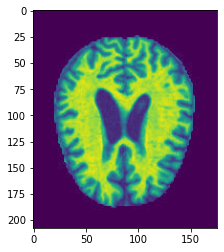

In [4]:
#Read and plot Sample Image
img=mpimg.imread('27.jpg')
imgplot = plt.imshow(img)

In [5]:
#Classes and Image dimensions
W_DIR = './dataset/'
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [6]:
#Performing Image Augmentation to have more data samples
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = work_dr.flow_from_directory(directory=W_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


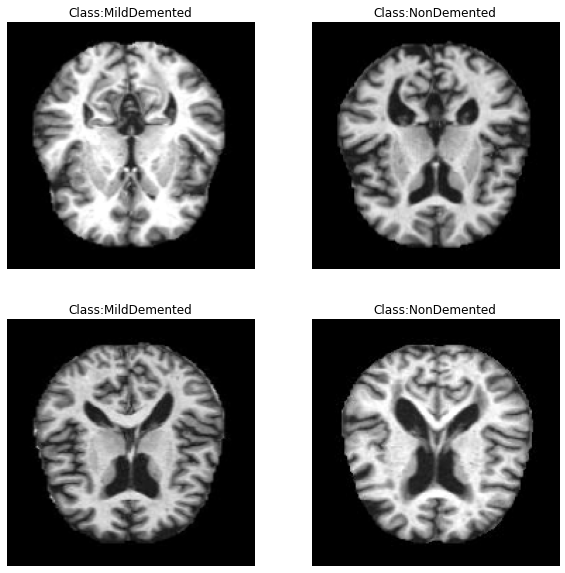

In [7]:
#Sample Images and classes
def show_images(generator,y_pred=None):
    """Input: An image generator,predicted labels (optional) Output: Displays a grid of 4 images with lables"""
   # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
   # get a batch of images
    x,y = generator.next()
   # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(4):
            ax = plt.subplot(2, 2, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
    else:
        for i in range(4):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
# Display Train Images
show_images(train_data_gen)

In [8]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()

In [9]:
#Getting to know the dimensions of our dataset
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [10]:
#Performing over-sampling of the data, since the classes are imbalanced
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [11]:
#Splitting the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [12]:
#Using the InceptionV3 model as a base model for the task
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [13]:
for layer in inception_model.layers:
    layer.trainable=False

In [14]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [15]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
my_callback = MyCallback()
#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [16]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]
CALLBACKS = [my_callback, rop_callback]
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

In [ ]:
#Fit the training data to the model and validate it using the validation data
#Use higher EPOCHS in production to get better accuracy
EPOCHS = 45
history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/45
256/256 [==============================] - 214s 817ms/step - loss: 1.3354 - acc: 0.4318 - auc: 0.7032 - f1_score: 0.4290 - val_loss: 0.7679 - val_acc: 0.6436 - val_auc: 0.8902 - val_f1_score: 0.6267 - lr: 0.0010
Epoch 2/45
256/256 [==============================] - 219s 855ms/step - loss: 0.8927 - acc: 0.5887 - auc: 0.8532 - f1_score: 0.5827 - val_loss: 0.6682 - val_acc: 0.6880 - val_auc: 0.9164 - val_f1_score: 0.6795 - lr: 0.0010
Epoch 3/45
256/256 [==============================] - 204s 799ms/step - loss: 0.7724 - acc: 0.6404 - auc: 0.8899 - f1_score: 0.6356 - val_loss: 0.6479 - val_acc: 0.6758 - val_auc: 0.9177 - val_f1_score: 0.6633 - lr: 0.0010
Epoch 4/45
256/256 [==============================] - 251s 981ms/step - loss: 0.7317 - acc: 0.6702 - auc: 0.9025 - f1_score: 0.6663 - val_loss: 0.5823 - val_acc: 0.7192 - val_auc: 0.9353 - val_f1_score: 0.6959 - lr: 0.0010
Epoch 5/45
256/256 [==============================] - 190s 741ms/step - loss: 0.6932 - acc: 0.6895 - auc: 0.

In [ ]:
#Plotting the trend of the metrics during training
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()
for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
#Evaluating the model on the data
#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)
#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

In [ ]:
#Predicting the test data
pred_labels = custom_inception_model.predict(test_data)

In [ ]:
#Print the classification report of the tested data
#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr
for labels in pred_labels:
    labels = roundoff(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

In [ ]:
#Plot the confusion matrix to understand the classification in detail
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)
conf_arr = confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
df_pred = pd.DataFrame(pred_ls,columns=['Predicted'])

In [ ]:
df_true = pd.DataFrame(test_ls,columns=['True'])

In [ ]:
df_combined = pd.concat([df_true.reset_index(drop=True), df_pred], axis=1)

In [ ]:
print(df_combined)

In [ ]:
df_combined['ID'] = np.arange(len(df_combined))
print (df_combined)

In [ ]:
#Export Results to csv
df_combined.to_csv(r'C:\Users\olajideajayi\OneDrive - Microsoft\Desktop\WIP\DICOM\df_combined.csv', index = False)

In [ ]:
#Printing some other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))

In [ ]:
#Saving the model for future use
custom_inception_model_dir = w_dir + "alzheimer_inception_cnn_model"
custom_inception_model.save(custom_inception_model_dir, save_format='h5')
os.listdir(w_dir)

In [ ]:
pretrained_model = tf.keras.models.load_model(custom_inception_model_dir)
#Check its architecture
plot_model(pretrained_model, to_file=w_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

In [ ]:
#Constructing a Convolutional Neural Network Architecture
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    return block

In [ ]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    return block

In [ ]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")
    return model

In [ ]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True           
my_callback = MyCallback()
#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
Final_Results_New=Final_Results.to_csv(index = False)

In [ ]:
storage_connection_string='DefaultEndpointsProtocol=https;AccountName=olastorageac;AccountKey=yyyyyyyyyyyyyyyyyyyyyyyyyyyy;EndpointSuffix=core.windows.net'
container_name = 'modeloutput'
dest_file_name = 'Final_Results_New.csv'

In [ ]:
blob_client = BlobClient.from_connection_string(storage_connection_string,container_name,dest_file_name)

In [ ]:
csv_content = Final_Results_New
blob_client.upload_blob(csv_content)